Import neccessary packages

In [1]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array

Using TensorFlow backend.


In [2]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = './data/plantvillage/'
width=256
height=256
depth=3

Function to convert images to array

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Fetch images from directory

In [4]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    print(root_dir)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
           
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
['Corn', 'Peppers', 'Potato', 'Cherry', 'Peach', 'Raspberry', 'Grape', 'Squash', 'Strawberry', 'Soybean', 'Apple', 'Tomato', 'Orange', 'Blueberry']
[INFO] Processing Corn_(maize)___Northern_Leaf_Blight ...
[INFO] Processing Corn_(maize)___Common_rust_ ...
[INFO] Processing Corn_(maize)___healthy ...
[INFO] Processing Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot ...
[INFO] Processing Pepper,_bell___healthy ...
[INFO] Processing Pepper,_bell___Bacterial_spot ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Cherry_(including_sour)___Powdery_mildew ...
[INFO] Processing Cherry_(including_sour)___healthy ...
[INFO] Processing Peach___Bacterial_spot ...
[INFO] Processing Peach___healthy ...
[INFO] Processing Raspberry___healthy ...
[INFO] Processing Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ...
[INFO] Processing Grape___Black_rot ...
[INFO] Processing Grape___he

Get Size of Processed Image

In [5]:
image_size = len(image_list)
print(image_size)

7552


Transform Image Labels uisng [Scikit Learn](http://scikit-learn.org/)'s LabelBinarizer

In [6]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

Print the classes

In [7]:
print(label_binarizer.classes_)

['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy' 'Blueberry___healthy'
 'Cherry_(including_sour)___Powdery_mildew'
 'Cherry_(including_sour)___healthy'
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
 'Corn_(maize)___Common_rust_' 'Corn_(maize)___Northern_Leaf_Blight'
 'Corn_(maize)___healthy' 'Grape___Black_rot'
 'Grape___Esca_(Black_Measles)'
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)' 'Grape___healthy'
 'Orange___Haunglongbing_(Citrus_greening)' 'Peach___Bacterial_spot'
 'Peach___healthy' 'Pepper,_bell___Bacterial_spot'
 'Pepper,_bell___healthy' 'Potato___Early_blight' 'Potato___Late_blight'
 'Potato___healthy' 'Raspberry___healthy' 'Soybean___healthy'
 'Squash___Powdery_mildew' 'Strawberry___Leaf_scorch'
 'Strawberry___healthy' 'Tomato___Bacterial_spot' 'Tomato___Early_blight'
 'Tomato___Late_blight' 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Target_Spot'
 'Tomato___Tom

In [8]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [9]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [10]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [11]:
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96,input_shape=(256,256,3), kernel_size=(11,11),\
 strides=(4,4), padding='valid'))
model.add(Activation('relu'))
# Pooling 
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
# Batch Normalisation before passing it to the next layer
model.add(BatchNormalization())

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
# Batch Normalisation
model.add(BatchNormalization())

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Batch Normalisation
#model.add(BatchNormalization())

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Batch Normalisation
#model.add(BatchNormalization())

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
# Batch Normalisation
model.add(BatchNormalization())

# Passing it to a dense layer
model.add(Flatten())
# 1st Dense Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())

# 2nd Dense Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())

# Output Layer
model.add(Dense(38))
model.add(Activation('softmax'))




Model Summary

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 96)        34944     
_________________________________________________________________
activation_1 (Activation)    (None, 62, 62, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 96)        384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 256)       614656    
_________________________________________________________________
activation_2 (Activation)    (None, 26, 26, 256)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 256)      

In [13]:
# (4) Compile 
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# train the network
print("[INFO] training network...")

[INFO] training network...


In [14]:
# (5) Train

history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/25
188/188 [==============================] - 88s 466ms/step - loss: 0.1334 - accuracy: 0.9695 - val_loss: 0.1856 - val_accuracy: 0.9633
Epoch 2/25
188/188 [==============================] - 83s 442ms/step - loss: 0.1214 - accuracy: 0.9695 - val_loss: 0.2434 - val_accuracy: 0.9561
Epoch 3/25
188/188 [==============================] - 83s 441ms/step - loss: 0.1109 - accuracy: 0.9703 - val_loss: 0.1926 - val_accuracy: 0.9634
Epoch 4/25
188/188 [==============================] - 83s 440ms/step - loss: 0.1036 - accuracy: 0.9712 - val_loss: 0.5089 - val_accuracy: 0.9513
Epoch 5/25
188/188 [==============================] - 82s 437ms/step - loss: 0.0952 - accuracy: 0.9726 - val_loss: 0.4072 - val_accuracy: 0.9527
Epoch 6/25
188/188 [==============================] - 82s 434ms/step - loss: 0.0894 - accuracy: 0.9736 - val_loss: 0.1795 - val_accuracy: 0.9635
Epoch 7/25
188/188 [==============================] - 81s 429ms/step - loss: 0.1072 - accuracy: 0.9718 - val_loss: 0.2107 - val_ac

Plot the train and val curve

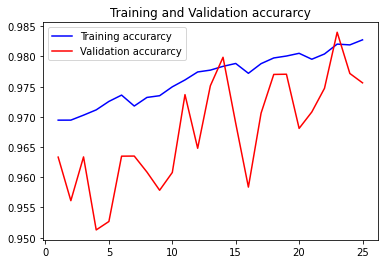

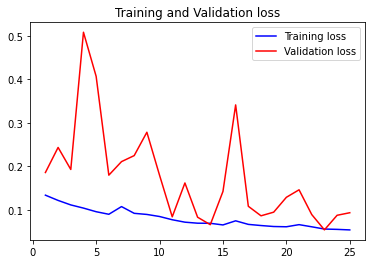

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Model Accuracy

In [16]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
1511/1511 [==============================] - 3s 2ms/step
Test Accuracy: 97.5634753704071


Save model using Pickle

In [17]:
# save the model to disk
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model.pkl', 'wb'))

[INFO] Saving model...
